# **Preliminary: Install and Import Packages**

In [2]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import requests
from io import StringIO


# **Import Data**

Import Data from the Source:
https://raw.githubusercontent.com/propublica/compas-analysis/master


In [3]:

# Downloading the COMPAS dataset from the provided GitHub URL
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas_data = requests.get(url).content

# Reading the downloaded data into a pandas DataFrame
compas_df = pd.read_csv(StringIO(compas_data.decode('utf-8')))



# **Process Data**

In [4]:
# Parameters for processing the data
# These parameters can be adjusted as needed
PROTECTED_CLASS = 1
UNPROTECTED_CLASS = 0
POSITIVE_OUTCOME = 1
NEGATIVE_OUTCOME = 0

# Filtering the dataset based on specific criteria
compas_df = compas_df.loc[(compas_df['days_b_screening_arrest'] <= 30) &
                          (compas_df['days_b_screening_arrest'] >= -30) &
                          (compas_df['is_recid'] != -1) &
                          (compas_df['c_charge_degree'] != "O") &
                          (compas_df['score_text'] != "NA")]

# Calculating the length of stay
compas_df['length_of_stay'] = (
            pd.to_datetime(compas_df['c_jail_out']) - pd.to_datetime(compas_df['c_jail_in'])).dt.days

# Selecting relevant columns
X = compas_df[['age', 'c_charge_degree', 'race', 'sex', 'priors_count', 'length_of_stay']]

# Assigning outcomes based on the score
y = np.array([NEGATIVE_OUTCOME if score == 'High' else POSITIVE_OUTCOME for score in compas_df['score_text']])
sens = X.pop('race')

# Converting categorical variables into dummy/indicator variables
X = pd.get_dummies(X)
sensitive_attr = np.array(pd.get_dummies(sens).pop('African-American'))
X['race'] = sensitive_attr

# Ensuring alignment of data
assert all((sens == 'African-American') == (X['race'] == PROTECTED_CLASS))

# Splitting the dataset into training and testing sets
X = X.drop(columns=['sex_Male', 'c_charge_degree_M'])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20)

# Adding risk column and saving the datasets
X_train['risk'] = y_train
X_test['risk'] = y_test

<ipython-input-4-a2869637a0f8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compas_df['length_of_stay'] = (


In [10]:
train = X_train
test = X_test
print(train.isnull().sum())
print(test.isnull().sum())

age                  0
priors_count         0
length_of_stay       0
c_charge_degree_F    0
sex_Female           0
race                 0
risk                 0
dtype: int64
age                  0
priors_count         0
length_of_stay       0
c_charge_degree_F    0
sex_Female           0
race                 0
risk                 0
dtype: int64


In [11]:
train

,age,priors_count,length_of_stay,c_charge_degree_F,sex_Female,race,risk
5985,26,5,2,1,0,1,1
833,48,25,6,1,0,1,0
65,29,4,18,1,0,1,0
740,23,0,0,1,0,1,1
6534,21,2,1,1,1,1,0
...,...,...,...,...,...,...,...
6831,42,1,0,1,0,1,1
6294,26,3,1,1,1,0,1
3268,33,1,0,1,0,0,1
3542,37,0,0,0,0,0,1


In [12]:
test

,age,priors_count,length_of_stay,c_charge_degree_F,sex_Female,race,risk
573,25,0,0,0,1,1,1
6439,28,6,1,0,0,0,1
4830,21,1,0,1,0,0,1
2843,23,2,6,1,0,1,0
3750,30,1,0,1,1,1,1
...,...,...,...,...,...,...,...
1060,27,2,20,1,0,1,1
3818,39,7,0,1,0,1,0
3691,37,2,0,0,0,0,1
277,30,11,1,1,0,1,1


In [14]:
train.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
age,4937.0,34.776382,11.842968,19.0,25.0,31.0,43.0,96.0
priors_count,4937.0,3.273648,4.798562,0.0,0.0,1.0,4.0,38.0
length_of_stay,4937.0,14.776990,47.286459,-1.0,0.0,1.0,6.0,799.0
c_charge_degree_F,4937.0,0.639255,0.480265,0.0,0.0,1.0,1.0,1.0
sex_Female,4937.0,0.196070,0.397063,0.0,0.0,0.0,0.0,1.0
race,4937.0,0.509216,0.499966,0.0,0.0,1.0,1.0,1.0
risk,4937.0,0.814665,0.388609,0.0,1.0,1.0,1.0,1.0


In [15]:
num_risk = train[train['risk'] == 1].shape[0]
print(f"Number of risk: {num_risk}")

Number of risk: 4022


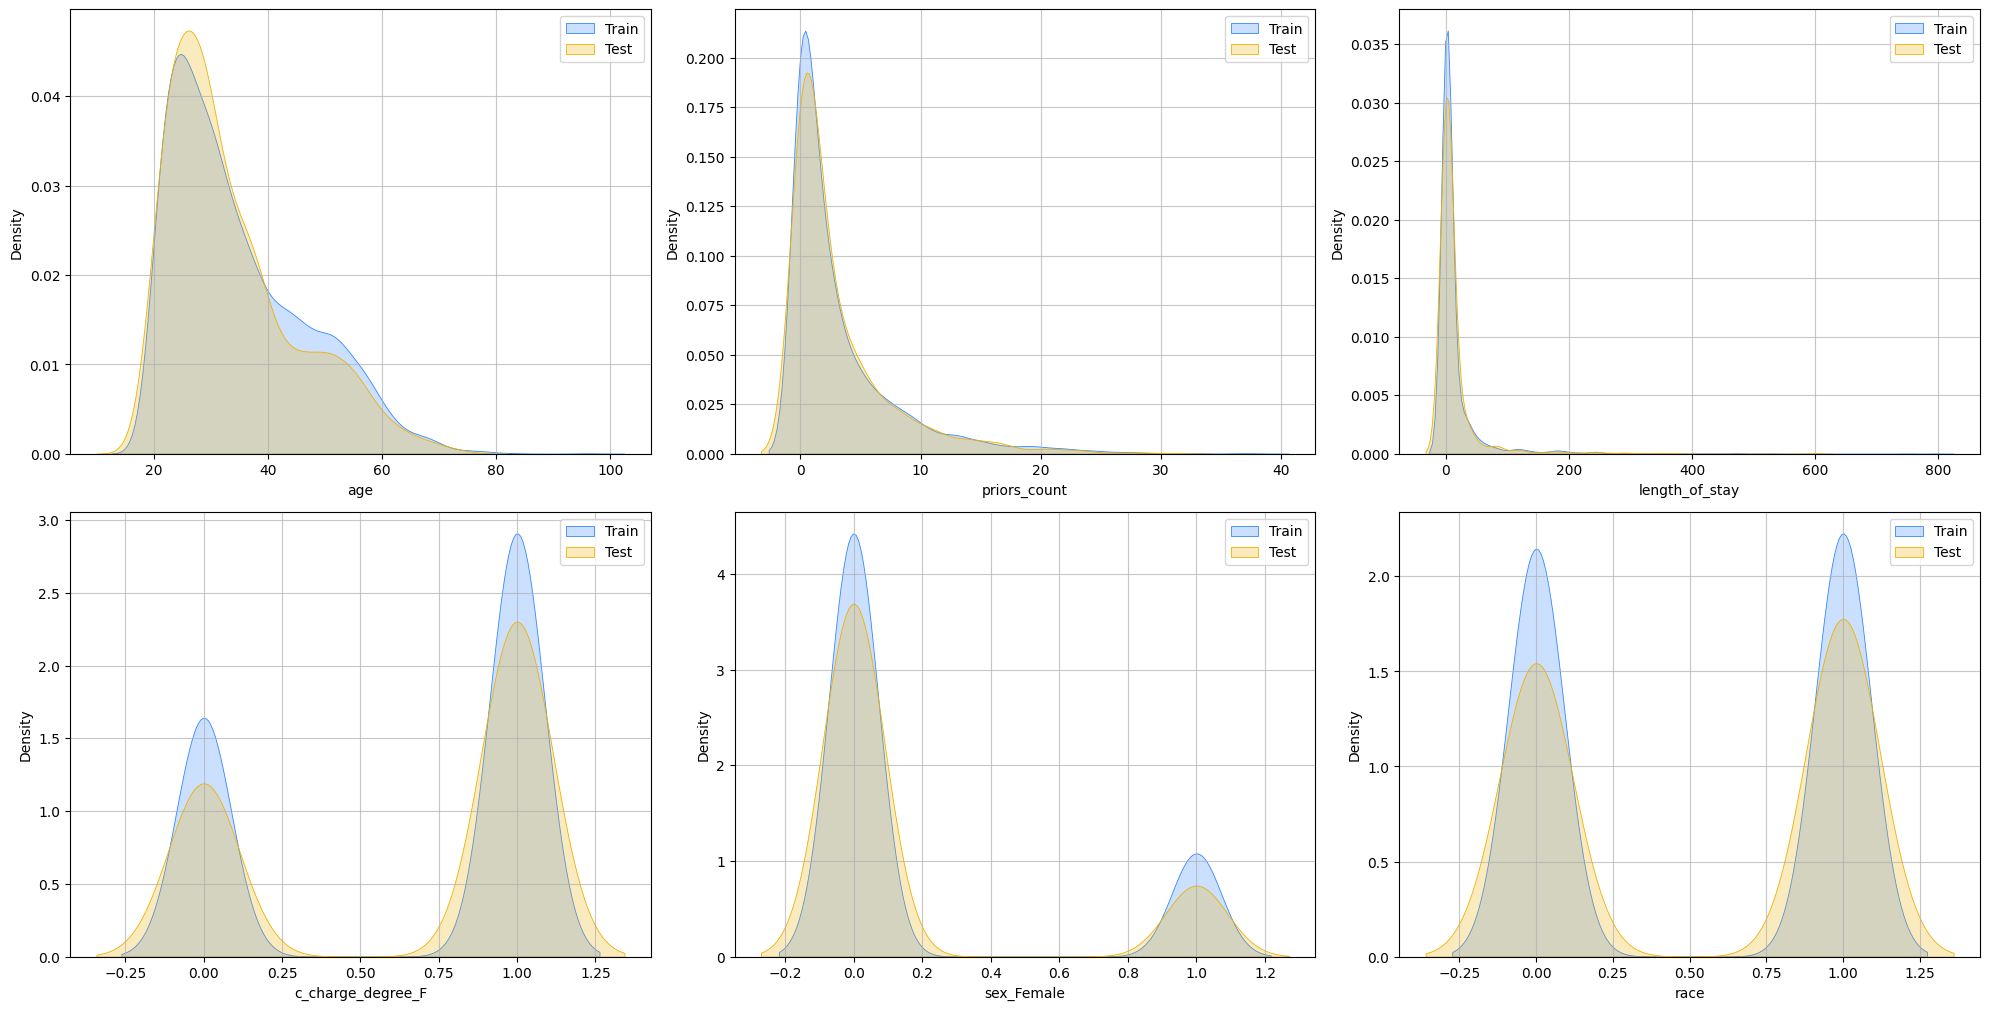

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = (list(X))

fig = plt.figure(figsize=(20, 50))
rows, cols = 10, 3
for idx, num in enumerate(numeric_columns[:30]):
    ax = fig.add_subplot(rows, cols, idx+1)
    ax.grid(alpha = 0.7, axis ="both")
    sns.kdeplot(x = num, fill = True,color ="#3386FF",linewidth=0.6, data = train, label = "Train")
    sns.kdeplot(x = num, fill = True,color ="#EFB000",linewidth=0.6, data = test, label = "Test")
    ax.set_xlabel(num)
    ax.legend()
fig.tight_layout()
fig.show()

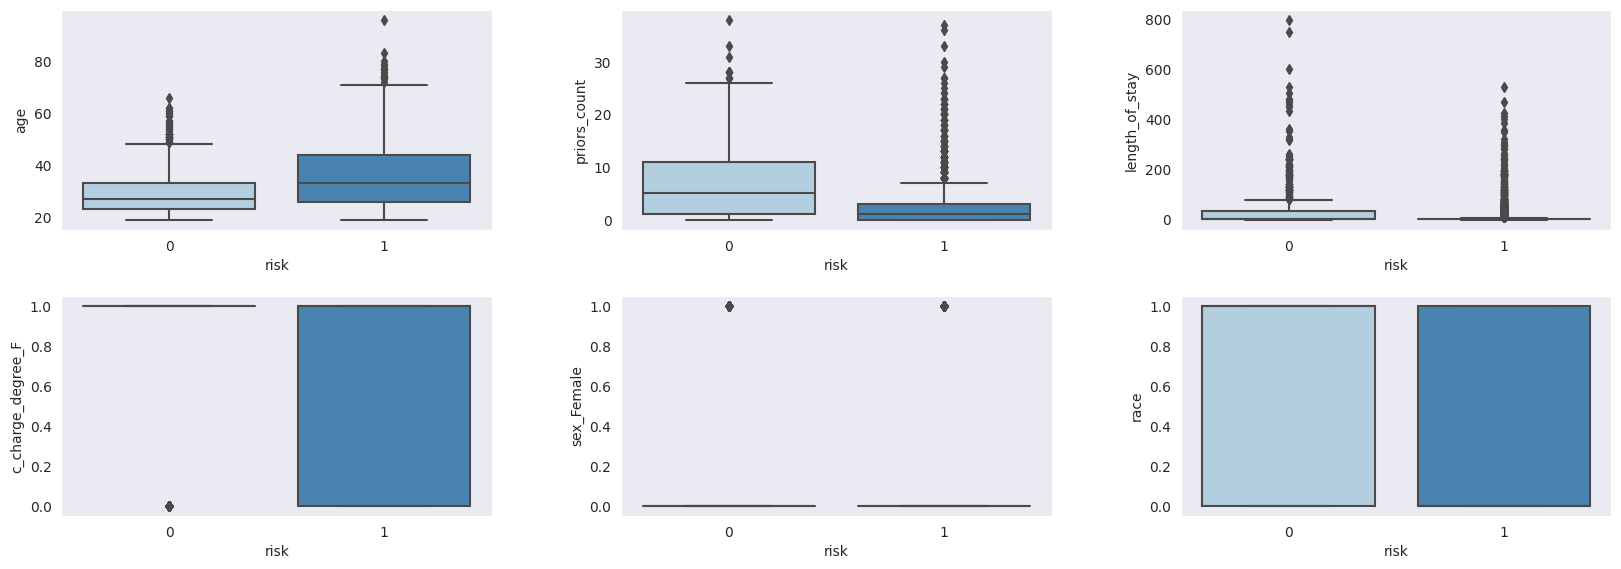

In [17]:
sns.set_style('dark')
fig = plt.figure(figsize= (20,40))
fig.subplots_adjust(hspace = 0.30, wspace = 0.30)
k=0
for i in range(1,len(train.columns)+1):
    ax = fig.add_subplot(11,3,i)
    sns.boxplot(x = 'risk',
                y = X.columns[k],
                data = train,
                palette = 'Blues')
    k = k + 1
    if k == len(X.columns): break
plt.show()

# **Export Data**


In [19]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)